In [1]:
import os
import time
import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams['figure.max_open_warning'] = 20
import seaborn as sns

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms

from torchvision.datasets import MNIST, EMNIST
from torch.utils.data import DataLoader
from torchvision.transforms.functional import rotate
import torchsummary

from models import VAE, convVAE, Classifier, convAE
from my_utils import *

seed = 0
torch.manual_seed(seed=seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed=seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Hyperparameters and network architecture 

In [3]:
rs = 14
crop = 12
real_size = rs if not crop else crop

epochs = 20
batch_size = 64
learning_rate = 0.001

print_every = 100
fig_root = 'imgs/EMNIST/HKU'
conditional = False

class_chosen = True
# classes = [43, 46, 56]  # byclass
classes = [17, 20, 30]  # byclass
# classes = [8, 11, 21]  # letters

latent_size = 2

vae = convVAE(latent_size=latent_size,
              re_size=real_size,
              c1_dim=8, c2_dim=16, lin_dim=16).to(device)


vae_used = True

## Dataset

In [5]:
my_trans = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((rs, rs), antialias=True),
                               transforms.CenterCrop((crop, crop)),])

dataset = EMNIST(root='./data', train=True, transform=my_trans, split='byclass', download=True)
print(dataset.class_to_idx)
# dataset = MNIST(root='data', train=True, transform=my_trans, download=True)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

dataset_test = EMNIST(root='./data', train=False, transform=my_trans, split='byclass', download=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)

if class_chosen:
    dataset_ = getdataset(data_loader, classes)
    print(dataset_[0].shape)
    dataset = MyDataset(dataset_[0], dataset_[1])
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test_ = getdataset(data_loader_test, classes)
    print(dataset_test_[0].shape)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'c': 38, 'd': 39, 'e': 40, 'f': 41, 'g': 42, 'h': 43, 'i': 44, 'j': 45, 'k': 46, 'l': 47, 'm': 48, 'n': 49, 'o': 50, 'p': 51, 'q': 52, 'r': 53, 's': 54, 't': 55, 'u': 56, 'v': 57, 'w': 58, 'x': 59, 'y': 60, 'z': 61}
torch.Size([18222, 1, 12, 12])
torch.Size([2905, 1, 12, 12])


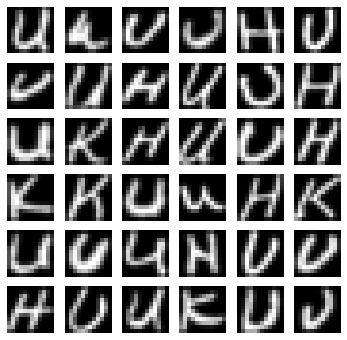

In [6]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
for i in range(6):
    for j in range(6):
        ax[i, j].imshow(torch.flip(torch.rot90(dataset[i*6+j][0].squeeze(0), k=1), dims=[0]), cmap='gray')
        ax[i, j].axis('off')
plt.show()

## Training

In [11]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, real_size*real_size), x.view(-1, real_size*real_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

def loss_fn_bce(recon_x, x):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, real_size*real_size), x.view(-1, real_size*real_size), reduction='sum')

    return BCE / x.size(0)

mu1 = [2*np.sqrt(3), 2]
mu2 = [-2*np.sqrt(3), 2]
mu3 = [0, -4]
mu_l = [mu1, mu2, mu3]


print(f"mu is {mu_l}")

def loss_fn_seperated(recon_x, x, y, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, real_size*real_size), x.view(-1, real_size*real_size), reduction='sum')
    
    mu = torch.Tensor([mu_l[int(k)] for k in y]).to(device)
    
    KLD = -0.5 * torch.sum(1 + log_var - (mean - mu).pow(2) - log_var.exp())

    return (BCE + 3*KLD) / x.size(0) 

epochs = 20
batch_size = 64
learning_rate = 0.001
c1_dim = 8
c2_dim = 16
lin_dim = 16


vae = convVAE(latent_size=latent_size,
              re_size=real_size,
              c1_dim=c1_dim, c2_dim=c2_dim, lin_dim=lin_dim).to(device)

model = vae

mu is [[3.4641016151377544, 2], [-3.4641016151377544, 2], [0, -4]]


In [15]:
def train_vae(readableTime, epochs=20, bs=64, lr=1e-3, c1_dim=8, c2_dim=16, lin_dim=16):
    para = f'{epochs}_{bs}_{lr}_{c1_dim}_{c2_dim}_{lin_dim}'

    model = convVAE(latent_size=latent_size,
                    re_size=real_size,
                    c1_dim=c1_dim, c2_dim=c2_dim, lin_dim=lin_dim).to(device)
    data_loader = DataLoader(dataset, batch_size=bs, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    logs = defaultdict(list)

    epoch = tqdm.trange(epochs)
    for ep in epoch:

        tracker_epoch = defaultdict(lambda: defaultdict(dict))

        for iteration, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)

            # print(f"input shape of x is {x.shape}")
            # print(f"label shape of y is {y.shape}")

            recon_x, mean, log_var, z = model(x)

            # print(f"recon shape of x is {recon_x.shape}")
            # print(f"mean shape is {mean.shape}")
            # print(f"log_var shape is {log_var.shape}")
            # print(f"z shape is {z.shape}")

            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()

            loss = loss_fn_seperated(recon_x, x, y, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if iteration % print_every == 0 or iteration == len(data_loader)-1:
                epoch.set_description(f"Epoch {ep:02d}/{epochs:02d} \
                    Batch {iteration:04d}/{len(data_loader)-1:d}, \
                    Loss {loss.item():9.4f}")

                z = torch.randn([36, latent_size]).to(device)*5
                x = model.inference(z)

                plt.figure(figsize=(6, 6))
                for p in range(36):
                    plt.subplot(6, 6, p+1)
                    plt.imshow(torch.flip(torch.rot90(x[p].view(real_size, real_size).cpu().data, k=1), dims=[0]).numpy())
                    plt.axis('off')

                if not os.path.exists(os.path.join(fig_root, str(readableTime), para)):
                    if not os.path.exists(os.path.join(fig_root, str(readableTime))):
                        if not(os.path.exists(os.path.join(fig_root))):
                            os.mkdir(os.path.join(fig_root))
                        os.mkdir(os.path.join(fig_root, str(readableTime)))
                    os.mkdir(os.path.join(fig_root, str(readableTime), para))

                plt.savefig(os.path.join(fig_root, str(readableTime), para, f"E{ep:d}I{iteration:d}.png"), dpi=300)
                plt.clf()
                plt.close('all')

        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        g = sns.lmplot(x='x', y='y', hue='label', data=df.groupby('label').head(1000), fit_reg=False, legend=True)
        g.savefig(os.path.join(fig_root, str(readableTime), para, f"E{ep:d}-Dist.png"), dpi=300)

    with open(os.path.join(fig_root, str(readableTime), para, 'loss.txt'), 'w') as f:
        for items in logs['loss']:
            f.write('%s\n' % items)

    torch.save(model.state_dict(), os.path.join(fig_root, str(readableTime), para, 'model.pth'))
    df.to_csv(os.path.join(fig_root, str(readableTime), para, 'HKU_raw.csv'), index=False)

    grid_num = 21
    scale = 7

    with torch.no_grad():
        x_labels = torch.linspace(-scale, scale, grid_num, device=device)
        y_labels = torch.linspace(-scale, scale, grid_num, device=device)
        xv, yv = torch.meshgrid(x_labels, y_labels, indexing='ij')
        grid = torch.stack([xv, yv], dim=2).view(-1, 2)

        fig, ax = plt.subplots(grid_num, grid_num, figsize=(10, 10))
        for i in range(grid_num):
            for j in range(grid_num):
                ax[i, j].imshow(torch.flip(torch.rot90(model.inference(grid)[i*grid_num+j][0].squeeze(0).cpu(), k=1), dims=[0]), cmap='gray')
                ax[i, j].axis('off')
        plt.savefig(os.path.join(fig_root, str(readableTime), para, 'HKU_grid.png'), dpi=300)

Epoch 19/20                     Batch 0284/284,                     Loss   65.8237: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


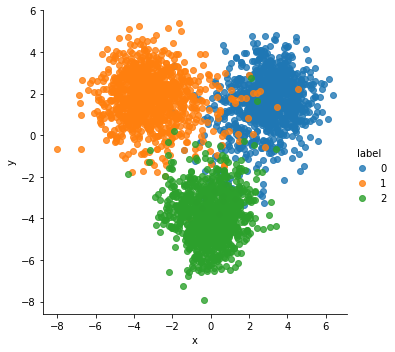

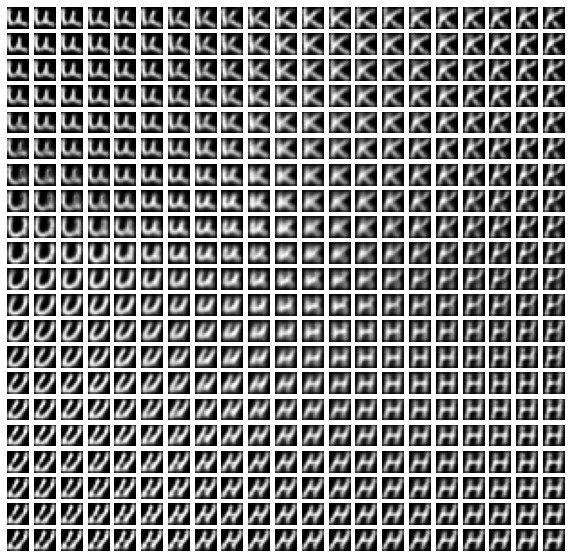

In [16]:
ts = time.time()
timeArray = time.localtime(ts)
readableTime = time.strftime("%Y-%m-%d-%H", timeArray)


epochs = 20
batch = 64
lr = 1e-3
c1 = 8
c2 = 16
lin = 16

train_vae(readableTime, epochs=epochs, bs=batch, lr=lr, c1_dim=c1, c2_dim=c2, lin_dim=lin)

In [7]:
time_stamp = '2023-12-27-22'
paras = '20_64_0.001_8_16_16'
model_file_path = f'imgs/EMNIST/HKU/{time_stamp}/{paras}/model.pth'

vae_load = convVAE(latent_size=latent_size,
                   re_size=real_size,
                   c1_dim=8, c2_dim=16, lin_dim=16).to(device)
model_statedict = torch.load(model_file_path, map_location=device)
vae_load.load_state_dict(model_statedict)

<All keys matched successfully>

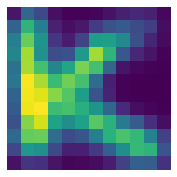

In [14]:
with torch.no_grad():
    x_init = [-0.67, -0.02]
    x__ = torch.Tensor(x_init).to(device) * 8
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(torch.flip(torch.rot90(vae_load.inference(x__)[0].squeeze(0).cpu(), k=1), dims=[0]))
    ax.axis('off')

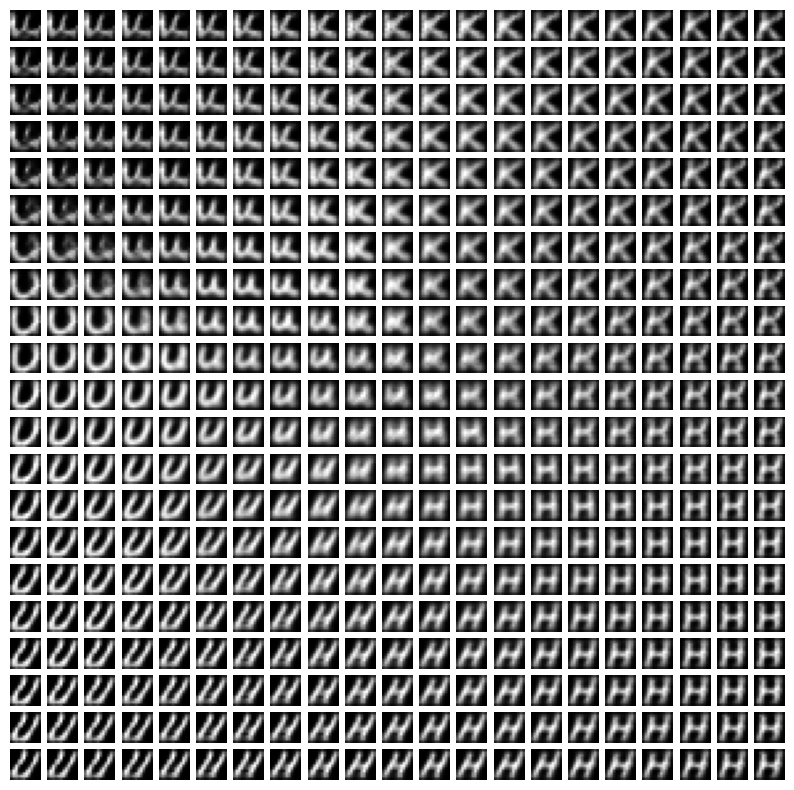

In [43]:
grid_num = 21
scale = 7

with torch.no_grad():
    x_labels = torch.linspace(-scale, scale, grid_num, device=device)
    y_labels = torch.linspace(-scale, scale, grid_num, device=device)
    xv, yv = torch.meshgrid(x_labels, y_labels)
    grid = torch.stack([xv, yv], dim=2).view(-1, 2)

    fig, ax = plt.subplots(grid_num, grid_num, figsize=(10, 10))
    for i in range(grid_num):
        for j in range(grid_num):
            ax[i, j].imshow(torch.flip(torch.rot90(vae_load.inference(grid)[i*grid_num+j][0].squeeze(0).cpu(), k=1), dims=[0]), cmap='gray')
            ax[i, j].axis('off')
    plt.show()